In [17]:
import numpy as np

In [18]:
class DenseLayer:
    def __init__(self,input_size,number_of_neurons) -> None:
        self.weights = np.random.randn(input_size,number_of_neurons)
        self.bias = np.random.randn(1,number_of_neurons)

    def forward(self,inputs):
        self.inputs = inputs 
        self.output = np.dot(self.inputs,self.weights)+self.bias

    def backward(self,dvalues):
        self.dweights = np.dot(self.inputs.T,dvalues)
        self.dbias = np.sum(dvalues,axis=0,keepdims=True)
        self.dinputs = np.dot(dvalues,self.weights.T)

class ReluActivation:
    def forward(self,inputs):
        self.inputs = inputs
        self.output = np.maximum(0,inputs)

    def backward(self,dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs<=0]=0
        
        
class Softmax:
    def forward(self,inputs):
        exp_inputs = np.exp(inputs-np.max(inputs,axis=1,keepdims=True))
        self.outputs = exp_inputs/(np.sum(exp_inputs,axis=1,keepdims=True))


class Loss:
    def calculate_loss(self,y_pred,y_actual):
        log_likelihood = self.forward(y_pred,y_actual)
        return np.mean(log_likelihood)

class CategoricalCrossEntropy(Loss):
    def forward(self,y_pred,y_actual):
        y_pred_clip = np.clip(y_pred,1e-7,1-1e-7)

        if (y_actual.ndim == 1):
            correct_confidence  = y_pred_clip[range(len(y_pred)),y_actual]
        elif (y_actual.ndim==2):
            correct_confidence = np.sum(y_pred_clip*y_actual,axis=1)
        else:
            raise ValueError("y_actual should be 1-dimensional (label encoded) or 2-dimensional (one-hot encoded).")

        log_likelihood = -np.log(correct_confidence)
        return log_likelihood

class Softmax_CategoricalCrossEntropy:
    def __init__(self) -> None:
        self.softmax = Softmax()
        self.CategoricalCrossEntropy = CategoricalCrossEntropy()
    
    def forward(self,inputs,y_actual):
        self.inputs = inputs
        self.softmax.forward(inputs)
        return self.CategoricalCrossEntropy.calculate_loss(self.softmax.outputs,y_actual)

    def backward(self,y_actual):
        y_pred = self.softmax.outputs
        if (y_actual.ndim == 1):
            num_of_classes = np.max(y_actual)+1
            y_actual = np.eye(num_of_classes)[y_actual]

        self.dinputs = y_pred - y_actual

class SGD_Optimizer:
    def __init__(self,learning_rate=1,decay=0,momentum=0):
        self.learning_rate = learning_rate
        self.decay = decay
        self.momentum = momentum
        self.iteration = 0
    
    def pre_update(self):
        if self.decay:
            self.current_learning_rate = (self.learning_rate)/(1.+(self.decay*self.iteration))
        else:
            self.current_learning_rate = self.learning_rate

    def parameter_update(self,layer):
        if self.momentum:
            if not hasattr(layer,'momentum_weights'):
                layer.momentum_weights = np.zeros_like(layer.weights)
                layer.momentum_bias = np.zeros_like(layer.bias)
            
            layer.momentum_weights = (-self.current_learning_rate*layer.dweights)+(layer.momentum_weights*self.momentum)
            layer.momentum_bias = (-self.current_learning_rate*layer.dbias)+(layer.momentum_bias*self.momentum)

            layer.weights += layer.momentum_weights
            layer.bias += layer.momentum_bias
        else:
            layer.weights += (-self.current_learning_rate*layer.dweights)
            layer.bias += (-self.current_learning_rate*layer.dbias)

    def post_update(self):
        if self.decay:
            self.iteration += 1

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import nnfs 
from nnfs.datasets import spiral_data
nnfs.init()

In [20]:
x,y = spiral_data(samples=99,classes=3)

<function matplotlib.pyplot.show(close=None, block=None)>

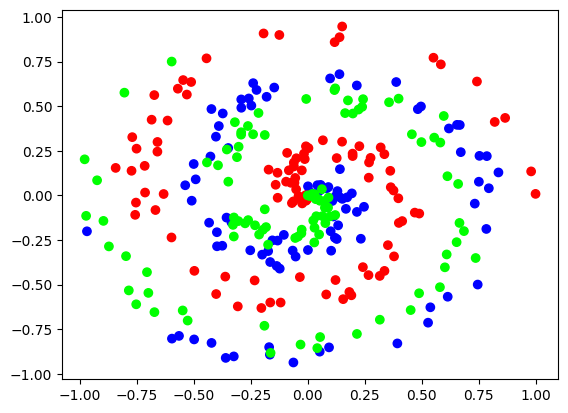

In [21]:
plt.scatter(x[:,0],x[:,1],c=y,cmap='brg')
plt.show